## Negative Binomial VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Negative Binomial base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = 0.05 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under GLMM with $\beta \sim$ randn(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.

We run each scenario 100 times and compare the fit of ours with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept
m  = 1    # number of variance components
# true parameter values
Random.seed!(1234)
βtrue = rand(Uniform(-0.2, 0.2), p)
rtrue = 10.0
θtrue = [0.05]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; rtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
  0.06364935
  0.308375456
  0.082183332
  0.228304837
  0.105207088
  0.36241125
  0.078623481
  0.156613346
  0.099462398
  0.289247059
  0.609230589
  0.197918249
  0.15500529
  ⋮
 17.745126337
 18.215457129
 18.803834158
 17.744055217
 17.882049016
 17.90089554
 17.701631701
 18.084194937
 17.922332938
 18.165475733
 18.132588662
 18.134551858

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
  0.264501145
  0.039862886
  0.026540404
  0.023277321
  0.026408589
  0.029954348
  0.05323124
  0.018587784
  0.060584256
  0.022395301
  0.019278478
  0.066484091
  0.06744692
  ⋮
 83.14532891
 69.38550645
 58.425630067
 65.142244945
 84.228615151
 74.25741305
 75.135948861
 95.754202553
 62.15070651
 70.176648174
 58.171686444
 74.243455423

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.268219,0.0184309,200,0.249789,0.28665,0.0013411
2,100,5,0.19723,0.0102491,500,0.186981,0.20748,0.000394461
3,100,10,0.218668,0.00318831,1000,0.21548,0.221857,0.000218668
4,100,15,0.240642,0.00241982,1500,0.238222,0.243061,0.000160428
5,100,20,0.26313,0.00179421,2000,0.261336,0.264925,0.000131565
6,100,25,0.287503,0.00163563,2500,0.285868,0.289139,0.000115001
7,1000,2,0.609081,0.0171668,2000,0.591915,0.626248,0.000304541
8,1000,5,0.693273,0.0048816,5000,0.688392,0.698155,0.000138655
9,1000,10,1.01275,0.00466995,10000,1.00808,1.01742,0.000101275


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0413375,0.00329045,200,0.0380471,0.044628,0.000206688
2,100,5,0.112739,0.00503557,500,0.107703,0.117775,0.000225478
3,100,10,0.264788,0.00769994,1000,0.257088,0.272488,0.000264788
4,100,15,0.414394,0.0140106,1500,0.400383,0.428405,0.000276263
5,100,20,0.552039,0.0220039,2000,0.530036,0.574043,0.00027602
6,100,25,0.7241,0.0379969,2500,0.686103,0.762097,0.00028964
7,1000,2,0.475741,0.0212626,2000,0.454478,0.497004,0.00023787
8,1000,5,1.50572,0.0686979,5000,1.43702,1.57441,0.000301143
9,1000,10,3.15882,0.0984762,10000,3.06035,3.2573,0.000315882


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


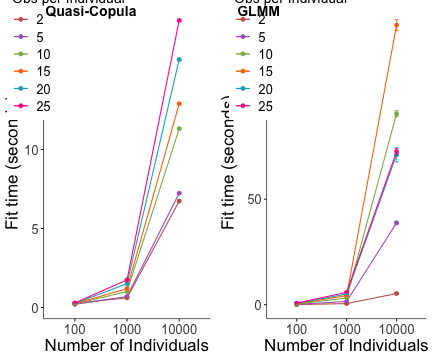

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
R"""
ggsave('sim_glmm_fittime_nsamples_nb_vs_glmm.png', fittime_nsamples, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_fittime_nsamples_nb_vs_glmm.png"


In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθrcoverage = readdlm("beta_r_sigma_coverage_multivariate_NB_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθrcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["r"]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p];  ["r"];  ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,r
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.16, 0.0368453)","(0.21, 0.040936)","(0.21, 0.040936)","(0.28, 0.0451261)"
2,N: 100 ni: 5,"(0.04, 0.0196946)","(0.12, 0.0326599)","(0.11, 0.0314466)","(0.03, 0.0171447)"
3,N: 100 ni: 10,"(0.01, 0.01)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
4,N: 100 ni: 15,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
5,N: 100 ni: 20,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
6,N: 100 ni: 25,"(0.0, 0.0)","(0.0, 0.0)","(0.01, 0.01)","(0.0, 0.0)"
7,N: 1000 ni: 2,"(0.06, 0.0238683)","(0.14, 0.0348735)","(0.12, 0.0326599)","(0.0, 0.0)"
8,N: 1000 ni: 5,"(0.03, 0.0171447)","(0.02, 0.0140705)","(0.0, 0.0)","(0.0, 0.0)"
9,N: 1000 ni: 10,"(0.03, 0.0171447)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult =  vec(readdlm("mse_r_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult_GLMM =  vec(readdlm("mse_r_GLMMmultivariate_NB_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, rmse = rMseresult,
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, rmse = rMseresult_GLMM,
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse];msedf1[!, :rmse]; msedf2[!, :betamse]; msedf2[!, :thetamse]; msedf2[!, :rmse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 3)]...) ; collect([repeat(msedf2[!, :obssize], 3)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 3)]...) ; collect([repeat(msedf2[!, :samplesize], 3)]...)]

parameters = [collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Negative Binomial QC"], 3 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Negative Binomial GLMM"],  3 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00333324,2,100,beta,Negative Binomial QC
2,0.00408972,2,100,beta,Negative Binomial QC
3,0.00457845,2,100,beta,Negative Binomial QC
4,0.00678895,2,100,beta,Negative Binomial QC
5,0.00943784,2,100,beta,Negative Binomial QC
6,0.0123173,2,100,beta,Negative Binomial QC
7,0.000250271,2,100,beta,Negative Binomial QC
8,0.00350172,2,100,beta,Negative Binomial QC
9,0.00240026,2,100,beta,Negative Binomial QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


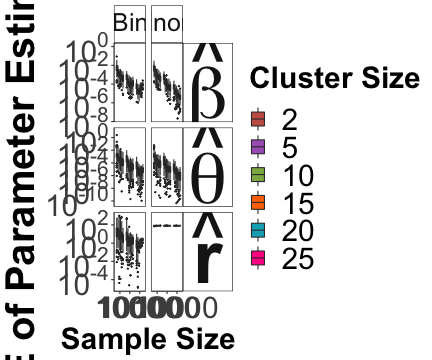

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-4]
msedfR[parameters == "theta",y_max := 10^1]
msedfR[parameters == "r", y_min := 10^-3]
msedfR[parameters == "r", y_max := 10^3]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta', 'r'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[]), r = expression(hat(bold(r))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Negative Binomial QC', 'Negative Binomial GLMM'),
    labels = c(expression(paste("Negative Binomial QC")), expression(paste("Negative Binomial GLMM"))))

#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [13]:
R"""
ggsave('sim_glmm_updated_msefacetplot_nb2.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_updated_msefacetplot_nb2.png"
